### Question 1
•	How do the spatial distribution and availability of public transportation services vary across different affordable units’ thresholds (30%, 50%, 80%, or 120% of AMI) in Washington DC?

In [30]:
!pip install osmnx

In [31]:
!pip install contextily

In [32]:
!pip install cartopy

In [33]:
!pip install folium

In [34]:
# Import libraries
import os
import pandas as pd
import geopandas as gpd
import osmnx as ox
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import folium
import contextily as cx
import seaborn as sns
from fiona.crs import from_epsg
from shapely.geometry import Point

In [35]:
# Define coordinate systems
UTM18 = from_epsg(26918)
WGS84 = 4326

In [36]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [37]:
# Set the working directory
os.chdir('/content/drive/MyDrive/Homie & John')

In [38]:
# Retrieve the street network for Washington, DC
place = 'Washington, DC, USA'
dc_network_g = ox.graph_from_place(place, network_type='walk')
dc_network_g = ox.project_graph(dc_network_g, to_crs=UTM18)
# Convert to geodataframes for easy plotting and exploration
dc_network_nodes, dc_network_edges = ox.graph_to_gdfs(dc_network_g)

In [39]:
# Read Affordable_Housing.shp and turn it into a gdf
ah_gdf = gpd.read_file('Affordable_Housing.shp')
ah_gdf = ah_gdf.to_crs(UTM18)
ah_gdf

,OBJECTID,MAR_WARD,ADDRESS,PROJECT_NA,STATUS_PUB,AGENCY_CAL,TOTAL_AFFO,LATITUDE,LONGITUDE,AFFORDABLE,...,AFFORDAB_2,AFFORDAB_3,AFFORDAB_4,CASE_ID,MAR_ID,XCOORD,YCOORD,FULLADDRES,GIS_LAST_M,geometry
0,100801,Ward 5,"4811 North Capitol Street Northeast, Washingto...",Tivoli Gardens TOPA,Completed 2015 to Date,DHCD,49,38.949302,-77.008458,4,...,37,0,0,None,288280,399266.82,142378.25,4811 NORTH CAPITOL STREET NE,2024-04-29,POINT (325952.315 4313069.550)
1,100802,Ward 2,"800 6th St NW, Washington, District of Columbi...",Wah Luck House,Completed 2015 to Date,DHCD,152,38.900229,-77.020189,0,...,152,0,0,None,279939,398248.70,136930.85,800 6TH STREET NW,2024-04-29,POINT (324814.918 4307645.656)
2,100803,Ward 8,"4216 4th Street Southeast, Washington, Distric...",Atlantic Gardens,Completed 2015 to Date,DCHFA DHCD,108,38.827812,-77.000060,44,...,0,0,0,None,147359,399994.81,128891.87,4216 4TH STREET SE,2024-04-29,POINT (326384.540 4299570.153)
3,100804,Ward 5,"3614 12th Street Northeast, Washington, Distri...",3614 12th St NE,Completed 2015 to Date,DHCD,1,38.934001,-76.991336,0,...,0,1,0,None,32748,400753.07,140682.71,3614 12TH STREET NE,2024-04-29,POINT (327401.029 4311341.771)
4,100805,Ward 1,"1315 Clifton St NW, Washington, District of Co...",Clifton Street,Completed 2015 to Date,DHCD OP,17,38.922704,-77.030589,0,...,0,4,0,15-03,232073,397347.15,139434.97,1315 CLIFTON STREET NW,2024-04-29,POINT (323968.474 4310169.020)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
895,101696,Ward 7,"3534 East Capitol Street Northeast, Washington...",3500 East Capitol Street NE Solstice Phase II,Completed 2015 to Date,DCHA DHCD,95,38.890110,-76.953627,5,...,0,0,0,None,287970,404061.06,135808.24,3534 EAST CAPITOL STREET NE,2024-04-29,POINT (330601.364 4306395.881)
896,101697,Ward 7,"401 Anacostia Road Southeast, Washington, Dist...",Mary's House,Under Construction,DCHA DHCD,15,38.884360,-76.955877,3,...,2,0,0,None,28142,403827.38,135168.32,401 ANACOSTIA ROAD SE,2024-04-29,POINT (330353.714 4305761.234)
897,101698,Ward 4,"930 Randolph Street Northwest, Washington, Dis...",Petworth Station Feb 2018,Completed 2015 to Date,DCHFA DHCD,84,38.938423,-77.025935,0,...,74,0,0,None,225073,397751.51,141170.91,930 RANDOLPH STREET NW,2024-04-29,POINT (324410.834 4311895.723)
898,101699,Ward 2,"1338 R Street Northwest, Washington, District ...",SOME - Anna Cooper House / Scattered Site III,Completed 2015 to Date,DCHFA DHCD,47,38.912369,-77.031151,47,...,0,0,0,None,242888,397298.35,138278.74,1338 R STREET NW,2024-04-29,POINT (323894.324 4309014.101)


In [40]:
# Read DC_Circulator_Stops.shp and turn it into a gdf
cbus_gdf = gpd.read_file('DC_Circulator_Stops.shp')
cbus_gdf = cbus_gdf.to_crs(UTM18)

cbus_gdf = cbus_gdf[['GLOBALID', 'geometry']]
cbus_gdf.head()

,GLOBALID,geometry
0,{1F9CE776-CE65-4BB9-96F0-D5089B07FE6F},POINT (326946.766 4305504.731)
1,{C75A53C6-D088-49DB-AC9F-037889634096},POINT (322097.622 4310400.337)
2,{D97D1B91-9213-4D1C-989D-E78FC8C29A3D},POINT (320705.907 4309476.758)
3,{4622ED92-B0F1-41E6-9A76-6FA890120E81},POINT (320930.180 4308921.068)
4,{00CF5C29-EC2D-44DC-A407-92AD054CEB47},POINT (321089.382 4308507.412)


In [41]:
# Read Metro_Bus_Stops.shp and turn it into a gdf
mbus_gdf = gpd.read_file('Metro_Bus_Stops.shp')
mbus_gdf = mbus_gdf.to_crs(UTM18)

mbus_gdf = mbus_gdf[['GLOBALID', 'geometry']]
mbus_gdf.head()

,GLOBALID,geometry
0,{CFF25BD1-E9E8-44CD-81D6-975FE646753F},POINT (319191.443 4314310.084)
1,{8E670BA7-FB63-4CAC-B9FC-C0901E266303},POINT (350901.110 4312462.098)
2,{22649B1B-617C-4511-9786-D465C7142788},POINT (311179.508 4300890.257)
3,{AE0E1A3F-7C1D-4410-9E47-01B20568BBE0},POINT (321586.776 4288231.856)
4,{2C8845FF-D723-4334-A3DD-4DFEA1B1C4C2},POINT (320673.657 4286908.488)


In [42]:
# Read Metro_Stations_Regional.shp and turn it into a gdf
metro_gdf = gpd.read_file('Metro_Stations_Regional.shp')
metro_gdf = metro_gdf.to_crs(UTM18)

metro_gdf = metro_gdf[['GLOBALID', 'geometry']]
metro_gdf.head()

,GLOBALID,geometry
0,{92A8B776-C7DD-4E1A-A9BF-83DBBFE3320F},POINT (334072.543 4299253.957)
1,{29FC24FF-2132-4F11-9D55-00ED0AD62B0E},POINT (321696.587 4298156.498)
2,{AC34C280-68C2-473F-88C6-7178859F27F1},POINT (321057.390 4297331.704)
3,{C137D724-61A0-4191-A166-14CADEF67A07},POINT (320168.018 4296667.729)
4,{68ACB463-D755-47C0-8907-AF039EDA5A8E},POINT (319775.447 4295953.806)


In [43]:
# Append cbus_gdf, mbus_gdf, and metro_gdf
stops_gdf = pd.concat([cbus_gdf, mbus_gdf])
stops_gdf = pd.concat([stops_gdf, metro_gdf])
stops_gdf

,GLOBALID,geometry
0,{1F9CE776-CE65-4BB9-96F0-D5089B07FE6F},POINT (326946.766 4305504.731)
1,{C75A53C6-D088-49DB-AC9F-037889634096},POINT (322097.622 4310400.337)
2,{D97D1B91-9213-4D1C-989D-E78FC8C29A3D},POINT (320705.907 4309476.758)
3,{4622ED92-B0F1-41E6-9A76-6FA890120E81},POINT (320930.180 4308921.068)
4,{00CF5C29-EC2D-44DC-A407-92AD054CEB47},POINT (321089.382 4308507.412)
...,...,...
93,{44EC9DFA-82ED-49C0-8DAE-8FBFDF00B9E0},POINT (290726.599 4315197.201)
94,{92F12286-0EB1-4911-AB70-A246401F35A9},POINT (287864.846 4314721.150)
95,{23354791-732C-4601-A04F-1C3A9248BDD7},POINT (286887.127 4318774.562)
96,{89C0E9DF-6D64-4795-90CC-801E9AE1ED4B},POINT (284255.024 4320317.157)


In [44]:
# Read Metro_Stations_Regional.shp and turn it into a gdf
dc_gdf = gpd.read_file('Washington_DC_Boundary_Stone_Area.shp')
dc_gdf = dc_gdf.to_crs(UTM18)

In [45]:
stops_gdf = gpd.clip(stops_gdf, dc_gdf)

In [46]:
stops_gdf

,GLOBALID,geometry
5500,{13DF21C9-AB3E-4BEF-B644-6062384505FD},POINT (325116.767 4298289.038)
142,{C059A6B4-939F-4AFE-81CC-42E85FCE4C90},POINT (325065.846 4298351.280)
143,{DB5DB32F-29D8-4999-BDB6-BBFBAC7B9E98},POINT (325025.171 4298368.009)
5600,{B3038279-DEA8-425F-8BE9-92C31636875C},POINT (325507.341 4298644.857)
7890,{6FEE70EF-4523-4083-B19B-FCB8F065DD73},POINT (325634.262 4298665.162)
...,...,...
7857,{5F1D95C3-8DDB-4900-BAC7-FA68CA4E1620},POINT (325256.824 4315997.058)
8455,{DC70CDC5-0F70-46C7-B6D8-DBCEB7438430},POINT (325257.017 4316017.485)
2304,{1B7ADE93-D413-4AC8-9832-E5BCA3198D26},POINT (325262.214 4316036.912)
40,{DDF7F2C1-C5E0-487C-B715-9CBCA7C05B36},POINT (325175.904 4316059.982)


<Axes: >

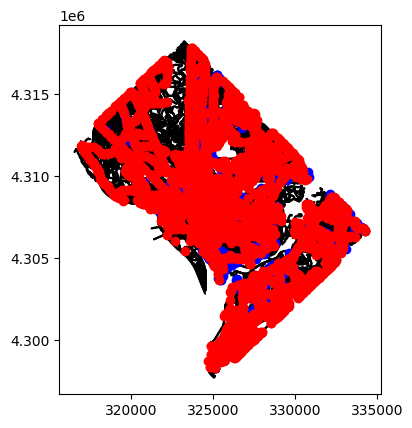

In [47]:
# Map data to make sure everything lines up
ax = dc_network_edges.plot(color='black', zorder=1)
ah_gdf.plot(ax=ax, color='blue', zorder=2)
stops_gdf.plot(ax=ax, color='red', zorder=3)

In [48]:
def find_nearest_points(gdf1, gdf2):
    nearest_points_data = []

    for idx1, row1 in gdf1.iterrows():
        point1 = row1.geometry
        nearest_point_index = None
        nearest_point_distance = float('inf')

        for idx2, row2 in gdf2.iterrows():
            point2 = row2.geometry
            distance = point1.distance(point2)

            if distance < nearest_point_distance:
                nearest_point_index = idx2
                nearest_point_distance = distance

        nearest_points_data.append({
            'original_index': idx1,
            'nearest_index': nearest_point_index,
            'distance': nearest_point_distance
        })

    nearest_points_df = gpd.GeoDataFrame(nearest_points_data)
    nearest_points_gdf = gdf1.merge(gdf2, left_on=nearest_points_df['nearest_index'], right_index=True)
    return nearest_points_gdf


In [66]:
nearest_stops_gdf = find_nearest_points(ah_gdf, stops_gdf)

In [119]:
f_nearest_stops_gdf = nearest_stops_gdf
f_nearest_stops_gdf

,key_0,OBJECTID,MAR_WARD,ADDRESS,PROJECT_NA,STATUS_PUB,AGENCY_CAL,TOTAL_AFFO,LATITUDE,LONGITUDE,...,AFFORDAB_4,CASE_ID,MAR_ID,XCOORD,YCOORD,FULLADDRES,GIS_LAST_M,geometry_x,GLOBALID,geometry_y
0,5138,100801,Ward 5,"4811 North Capitol Street Northeast, Washingto...",Tivoli Gardens TOPA,Completed 2015 to Date,DHCD,49,38.949302,-77.008458,...,0,None,288280,399266.82,142378.25,4811 NORTH CAPITOL STREET NE,2024-04-29,POINT (325952.315 4313069.550),{D3517D86-8CBC-4D05-808E-0FDA7E5D4EFF},POINT (325938.520 4312931.194)
1,1596,100802,Ward 2,"800 6th St NW, Washington, District of Columbi...",Wah Luck House,Completed 2015 to Date,DHCD,152,38.900229,-77.020189,...,0,None,279939,398248.70,136930.85,800 6TH STREET NW,2024-04-29,POINT (324814.918 4307645.656),{ED9B6976-72A3-4F29-B81F-ACDACB277B99},POINT (324832.554 4307669.798)
2,9099,100803,Ward 8,"4216 4th Street Southeast, Washington, Distric...",Atlantic Gardens,Completed 2015 to Date,DCHFA DHCD,108,38.827812,-77.000060,...,0,None,147359,399994.81,128891.87,4216 4TH STREET SE,2024-04-29,POINT (326384.540 4299570.153),{9B5398CC-053D-4B45-9ED4-263F28C6BF2E},POINT (326336.748 4299669.167)
126,9099,100927,Ward 8,"4315 3rd Street Southeast, Washington, Distric...",Atlantic Terrace,Completed 2015 to Date,DCHFA DHCD,195,38.828411,-77.002833,...,0,None,295774,399754.04,128958.34,4315 3RD STREET SE,2024-04-29,POINT (326145.277 4299641.879),{9B5398CC-053D-4B45-9ED4-263F28C6BF2E},POINT (326336.748 4299669.167)
740,9099,101541,Ward 8,"4201 4th Street Southeast, Washington, Distric...",Southern Hills Apartments Phase 1,Pipeline,DCHFA DHCD,81,38.829333,-77.001515,...,0,None,149584,399918.91,129048.60,4201 4TH STREET SE,2024-04-29,POINT (326312.087 4299728.510),{9B5398CC-053D-4B45-9ED4-263F28C6BF2E},POINT (326336.748 4299669.167)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
887,127,101688,Ward 6,"35 Parker Row Southwest, Washington, District ...",The Tides and Amaris (Parcel 8 and 9) - The Wh...,Completed 2015 to Date,DMPED DHCD OP,62,38.877261,-77.021631,...,74,11-03J,331860,398123.05,134381.30,35 PARKER ROW SW,2024-04-29,POINT (324633.410 4305099.399),{E15F96EA-4907-451C-BAFD-CDEEF0E5F5E4},POINT (327242.399 4304618.040)
890,6242,101691,Ward 1,"205 v Street Northwest, Washington, District o...",205 V St NW,Completed 2015 to Date,DHCD,1,38.918912,-77.015260,...,0,None,229527,398678.72,139000.45,205 V STREET NW,2024-04-29,POINT (325290.231 4309705.384),{F296CF19-F93D-4DBA-B71E-CF44C02EB3E3},POINT (325318.132 4309786.400)
891,2235,101692,Ward 5,"1676 Maryland Avenue Northeast, Washington, Di...",Flats at Atlas Phase II,Completed 2015 to Date,DHCD,24,38.901972,-76.979869,...,0,None,310898,401746.23,137124.38,1676 MARYLAND AVENUE NE,2024-04-29,POINT (328315.923 4307762.461),{589EB225-66DC-4F0F-AF5E-4F57D7B998BC},POINT (328362.518 4307732.380)
896,3448,101697,Ward 7,"401 Anacostia Road Southeast, Washington, Dist...",Mary's House,Under Construction,DCHA DHCD,15,38.884360,-76.955877,...,0,None,28142,403827.38,135168.32,401 ANACOSTIA ROAD SE,2024-04-29,POINT (330353.714 4305761.234),{0D7EC91F-A809-48F5-B342-5AF9AB878494},POINT (330222.744 4305720.484)


In [120]:
f_nearest_stops_gdf = pd.DataFrame(f_nearest_stops_gdf)
f_nearest_stops_gdf = f_nearest_stops_gdf.drop_duplicates(subset='OBJECTID', keep='last')
f_nearest_stops_gdf

,key_0,OBJECTID,MAR_WARD,ADDRESS,PROJECT_NA,STATUS_PUB,AGENCY_CAL,TOTAL_AFFO,LATITUDE,LONGITUDE,...,AFFORDAB_4,CASE_ID,MAR_ID,XCOORD,YCOORD,FULLADDRES,GIS_LAST_M,geometry_x,GLOBALID,geometry_y
0,5138,100801,Ward 5,"4811 North Capitol Street Northeast, Washingto...",Tivoli Gardens TOPA,Completed 2015 to Date,DHCD,49,38.949302,-77.008458,...,0,None,288280,399266.82,142378.25,4811 NORTH CAPITOL STREET NE,2024-04-29,POINT (325952.315 4313069.550),{D3517D86-8CBC-4D05-808E-0FDA7E5D4EFF},POINT (325938.520 4312931.194)
1,1596,100802,Ward 2,"800 6th St NW, Washington, District of Columbi...",Wah Luck House,Completed 2015 to Date,DHCD,152,38.900229,-77.020189,...,0,None,279939,398248.70,136930.85,800 6TH STREET NW,2024-04-29,POINT (324814.918 4307645.656),{ED9B6976-72A3-4F29-B81F-ACDACB277B99},POINT (324832.554 4307669.798)
2,9099,100803,Ward 8,"4216 4th Street Southeast, Washington, Distric...",Atlantic Gardens,Completed 2015 to Date,DCHFA DHCD,108,38.827812,-77.000060,...,0,None,147359,399994.81,128891.87,4216 4TH STREET SE,2024-04-29,POINT (326384.540 4299570.153),{9B5398CC-053D-4B45-9ED4-263F28C6BF2E},POINT (326336.748 4299669.167)
126,9099,100927,Ward 8,"4315 3rd Street Southeast, Washington, Distric...",Atlantic Terrace,Completed 2015 to Date,DCHFA DHCD,195,38.828411,-77.002833,...,0,None,295774,399754.04,128958.34,4315 3RD STREET SE,2024-04-29,POINT (326145.277 4299641.879),{9B5398CC-053D-4B45-9ED4-263F28C6BF2E},POINT (326336.748 4299669.167)
740,9099,101541,Ward 8,"4201 4th Street Southeast, Washington, Distric...",Southern Hills Apartments Phase 1,Pipeline,DCHFA DHCD,81,38.829333,-77.001515,...,0,None,149584,399918.91,129048.60,4201 4TH STREET SE,2024-04-29,POINT (326312.087 4299728.510),{9B5398CC-053D-4B45-9ED4-263F28C6BF2E},POINT (326336.748 4299669.167)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
887,127,101688,Ward 6,"35 Parker Row Southwest, Washington, District ...",The Tides and Amaris (Parcel 8 and 9) - The Wh...,Completed 2015 to Date,DMPED DHCD OP,62,38.877261,-77.021631,...,74,11-03J,331860,398123.05,134381.30,35 PARKER ROW SW,2024-04-29,POINT (324633.410 4305099.399),{E15F96EA-4907-451C-BAFD-CDEEF0E5F5E4},POINT (327242.399 4304618.040)
890,6242,101691,Ward 1,"205 v Street Northwest, Washington, District o...",205 V St NW,Completed 2015 to Date,DHCD,1,38.918912,-77.015260,...,0,None,229527,398678.72,139000.45,205 V STREET NW,2024-04-29,POINT (325290.231 4309705.384),{F296CF19-F93D-4DBA-B71E-CF44C02EB3E3},POINT (325318.132 4309786.400)
891,2235,101692,Ward 5,"1676 Maryland Avenue Northeast, Washington, Di...",Flats at Atlas Phase II,Completed 2015 to Date,DHCD,24,38.901972,-76.979869,...,0,None,310898,401746.23,137124.38,1676 MARYLAND AVENUE NE,2024-04-29,POINT (328315.923 4307762.461),{589EB225-66DC-4F0F-AF5E-4F57D7B998BC},POINT (328362.518 4307732.380)
896,3448,101697,Ward 7,"401 Anacostia Road Southeast, Washington, Dist...",Mary's House,Under Construction,DCHA DHCD,15,38.884360,-76.955877,...,0,None,28142,403827.38,135168.32,401 ANACOSTIA ROAD SE,2024-04-29,POINT (330353.714 4305761.234),{0D7EC91F-A809-48F5-B342-5AF9AB878494},POINT (330222.744 4305720.484)


In [121]:
f_nearest_stops_gdf = f_nearest_stops_gdf.drop(columns=['geometry_x'])
f_nearest_stops_gdf

,key_0,OBJECTID,MAR_WARD,ADDRESS,PROJECT_NA,STATUS_PUB,AGENCY_CAL,TOTAL_AFFO,LATITUDE,LONGITUDE,...,AFFORDAB_3,AFFORDAB_4,CASE_ID,MAR_ID,XCOORD,YCOORD,FULLADDRES,GIS_LAST_M,GLOBALID,geometry_y
0,5138,100801,Ward 5,"4811 North Capitol Street Northeast, Washingto...",Tivoli Gardens TOPA,Completed 2015 to Date,DHCD,49,38.949302,-77.008458,...,0,0,None,288280,399266.82,142378.25,4811 NORTH CAPITOL STREET NE,2024-04-29,{D3517D86-8CBC-4D05-808E-0FDA7E5D4EFF},POINT (325938.520 4312931.194)
1,1596,100802,Ward 2,"800 6th St NW, Washington, District of Columbi...",Wah Luck House,Completed 2015 to Date,DHCD,152,38.900229,-77.020189,...,0,0,None,279939,398248.70,136930.85,800 6TH STREET NW,2024-04-29,{ED9B6976-72A3-4F29-B81F-ACDACB277B99},POINT (324832.554 4307669.798)
2,9099,100803,Ward 8,"4216 4th Street Southeast, Washington, Distric...",Atlantic Gardens,Completed 2015 to Date,DCHFA DHCD,108,38.827812,-77.000060,...,0,0,None,147359,399994.81,128891.87,4216 4TH STREET SE,2024-04-29,{9B5398CC-053D-4B45-9ED4-263F28C6BF2E},POINT (326336.748 4299669.167)
126,9099,100927,Ward 8,"4315 3rd Street Southeast, Washington, Distric...",Atlantic Terrace,Completed 2015 to Date,DCHFA DHCD,195,38.828411,-77.002833,...,0,0,None,295774,399754.04,128958.34,4315 3RD STREET SE,2024-04-29,{9B5398CC-053D-4B45-9ED4-263F28C6BF2E},POINT (326336.748 4299669.167)
740,9099,101541,Ward 8,"4201 4th Street Southeast, Washington, Distric...",Southern Hills Apartments Phase 1,Pipeline,DCHFA DHCD,81,38.829333,-77.001515,...,0,0,None,149584,399918.91,129048.60,4201 4TH STREET SE,2024-04-29,{9B5398CC-053D-4B45-9ED4-263F28C6BF2E},POINT (326336.748 4299669.167)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
887,127,101688,Ward 6,"35 Parker Row Southwest, Washington, District ...",The Tides and Amaris (Parcel 8 and 9) - The Wh...,Completed 2015 to Date,DMPED DHCD OP,62,38.877261,-77.021631,...,0,74,11-03J,331860,398123.05,134381.30,35 PARKER ROW SW,2024-04-29,{E15F96EA-4907-451C-BAFD-CDEEF0E5F5E4},POINT (327242.399 4304618.040)
890,6242,101691,Ward 1,"205 v Street Northwest, Washington, District o...",205 V St NW,Completed 2015 to Date,DHCD,1,38.918912,-77.015260,...,0,0,None,229527,398678.72,139000.45,205 V STREET NW,2024-04-29,{F296CF19-F93D-4DBA-B71E-CF44C02EB3E3},POINT (325318.132 4309786.400)
891,2235,101692,Ward 5,"1676 Maryland Avenue Northeast, Washington, Di...",Flats at Atlas Phase II,Completed 2015 to Date,DHCD,24,38.901972,-76.979869,...,0,0,None,310898,401746.23,137124.38,1676 MARYLAND AVENUE NE,2024-04-29,{589EB225-66DC-4F0F-AF5E-4F57D7B998BC},POINT (328362.518 4307732.380)
896,3448,101697,Ward 7,"401 Anacostia Road Southeast, Washington, Dist...",Mary's House,Under Construction,DCHA DHCD,15,38.884360,-76.955877,...,0,0,None,28142,403827.38,135168.32,401 ANACOSTIA ROAD SE,2024-04-29,{0D7EC91F-A809-48F5-B342-5AF9AB878494},POINT (330222.744 4305720.484)


In [122]:
f_nearest_stops_gdf = f_nearest_stops_gdf.rename(columns={'geometry_y': 'geometry'})

In [123]:
f_nearest_stops_gdf = gpd.GeoDataFrame(f_nearest_stops_gdf)
f_nearest_stops_gdf = f_nearest_stops_gdf.to_crs(UTM18)

f_nearest_stops_gdf = f_nearest_stops_gdf[['GLOBALID', 'geometry']]
f_nearest_stops_gdf

,GLOBALID,geometry
0,{D3517D86-8CBC-4D05-808E-0FDA7E5D4EFF},POINT (325938.520 4312931.194)
1,{ED9B6976-72A3-4F29-B81F-ACDACB277B99},POINT (324832.554 4307669.798)
2,{9B5398CC-053D-4B45-9ED4-263F28C6BF2E},POINT (326336.748 4299669.167)
126,{9B5398CC-053D-4B45-9ED4-263F28C6BF2E},POINT (326336.748 4299669.167)
740,{9B5398CC-053D-4B45-9ED4-263F28C6BF2E},POINT (326336.748 4299669.167)
...,...,...
887,{E15F96EA-4907-451C-BAFD-CDEEF0E5F5E4},POINT (327242.399 4304618.040)
890,{F296CF19-F93D-4DBA-B71E-CF44C02EB3E3},POINT (325318.132 4309786.400)
891,{589EB225-66DC-4F0F-AF5E-4F57D7B998BC},POINT (328362.518 4307732.380)
896,{0D7EC91F-A809-48F5-B342-5AF9AB878494},POINT (330222.744 4305720.484)


In [124]:
f_nearest_stops_gdf.to_file('f_nearest_stops_gdf.shp')

In [125]:
# Find the nearest node to ah_gdf
ah_gdf_nodes, ah_gdf_node_dists = ox.nearest_nodes(
    dc_network_g,
    ah_gdf.geometry.get_coordinates().x,
    ah_gdf.geometry.get_coordinates().y,
    return_dist=True)

In [126]:
len(ah_gdf_node_dists)

900

In [127]:
# Find the nearest node to f_nearest_stops_gdf
f_nearest_stops_gdf_nodes, f_nearest_stops_gdf_node_dists = ox.nearest_nodes(
    dc_network_g,
    f_nearest_stops_gdf.geometry.get_coordinates().x,
    f_nearest_stops_gdf.geometry.get_coordinates().y,
    return_dist=True)

In [128]:
len(f_nearest_stops_gdf_nodes)

900

In [129]:
# impute speed on all edges missing data
dc_network_g = ox.add_edge_speeds(dc_network_g)

# calculate travel time (seconds) for all edges
dc_network_g = ox.add_edge_travel_times(dc_network_g)

# Convert to geodataframes
dc_network_nodes, dc_network_edges = ox.graph_to_gdfs(dc_network_g)

In [130]:
route = ox.shortest_path(
    dc_network_g,
    ah_gdf_nodes,
    f_nearest_stops_gdf_nodes,
    weight='travel_time',
)

In [131]:
type(route)

list

In [132]:
# Add up travel time and distance along the route
ox.routing.route_to_gdf(dc_network_g, route)['travel_time'].sum()

NetworkXError: Node [2399348228, 5440993470, 49740634] in sequence nbunch is not a valid node.

In [104]:
ox.routing.route_to_gdf(dc_network_g, route)['length'].sum()

NetworkXError: Node [2399348228, 5440993470, 49740634] in sequence nbunch is not a valid node.

In [102]:
def shortest_paths(graph, o_nodes, d_node, weight='length'):
    # Calculate shortest paths between each O-D pair
    d_nodes = [d_node] * len(o_nodes)
    routes = ox.shortest_path(graph, o_nodes, d_nodes, weight)
    # Gather data for edges along each route
    combined_route_edges = []
    for route_id, route in enumerate(routes):
        route_edges = ox.routing.route_to_gdf(dc_network_g, route)
        route_edges['route_id'] = route_id
        combined_route_edges.append(route_edges)
    combined_route_edges = pd.concat(combined_route_edges, axis=0)
    # Sum length and travel time for edges involved with each route
    route_summaries = combined_route_edges.groupby('route_id')[
        ['length','travel_time']].sum()
    # Clean up column names
    route_summaries = route_summaries.rename(
        columns={'length':'dist_to_nearest_stop',
                 'travel_time': 'time_to_nearest_stop'})
    return route_summaries

In [103]:
shortest_paths(dc_network_g, ah_gdf_nodes, f_nearest_stops_gdf_nodes, weight='length')

NodeNotFound: Either source 2399348228 or target [49740634, 3519479352, 5443092251, 5443092251, 5443092251, 49788457, 49788457, 49788457, 3954008860, 10608289921, 11357227041, 5206493236, 11516213105, 11516213105, 11516213105, 11516213105, 11516213105, 11516213105, 49795905, 4155621776, 49749954, 11491455777, 11491455777, 11491455777, 11491455777, 11512086454, 5581929188, 5581929188, 5581929188, 5581929188, 11484348400, 11484348400, 11484348400, 11484348400, 11484348400, 11484348400, 11228276618, 10939913219, 8455863363, 8455863363, 8455863363, 8455863363, 8455863363, 3007425104, 11218289768, 11218289768, 11218289768, 11218289768, 9136839313, 9136839313, 49745395, 49745395, 11230125761, 11230125761, 11230125761, 11230125761, 49851445, 49851445, 49851445, 7153301361, 7153301361, 7153301361, 49789305, 49789305, 3370912526, 3370912526, 11867325410, 11867325410, 11867325410, 11867325410, 49758370, 49815687, 49815687, 49815687, 49815687, 3370866914, 3370866914, 49789381, 49789381, 49772747, 49772747, 49772747, 49798815, 49798815, 8776517198, 6927560765, 6927560765, 11194759883, 11194759883, 11194759883, 11194759883, 10939913219, 10939913219, 3781487743, 3781487743, 5022968135, 49745256, 49745256, 49745256, 2591033445, 2591033445, 8784169209, 8784169209, 49767506, 49767506, 9525307418, 9525307418, 3370866947, 5703942830, 3667966672, 5441329947, 5441329947, 5440465407, 5440465407, 5440465407, 9723923071, 9602167158, 9602167158, 49852910, 49852910, 49852910, 49852910, 49789356, 49789356, 3253147394, 9210270979, 9210270979, 9210270979, 9210270979, 49817091, 49817091, 3005657159, 11248574605, 11248574605, 11248574605, 49789356, 49789356, 49789356, 49789356, 8851614060, 6356688266, 6356688266, 6356688266, 9216957867, 9216957867, 9216957867, 9822398192, 9722529582, 10112823621, 10112823621, 10112823621, 49830546, 638211057, 638211057, 638211057, 5018347891, 7780593110, 7780593110, 49760432, 3214044595, 3798943055, 3798943055, 49858173, 9723866486, 11078859391, 11117376085, 11117376085, 8455862981, 8455862981, 8455862981, 8455862981, 11344937233, 9481540443, 11382550128, 11382550128, 11382550128, 11382550128, 11382550128, 11382550128, 11382550128, 8564104579, 8564104579, 11117478992, 11117478992, 11117478992, 11117478992, 11117478992, 11117478992, 11117478992, 11117478992, 11117478992, 11117478992, 11435035026, 9736045227, 49763609, 49763609, 5445925209, 3954008716, 2906384898, 9136839291, 9136839291, 9644621279, 11612523776, 8459178665, 8459178665, 49755352, 11396157394, 8202303709, 49898275, 49898275, 49898275, 8319508826, 49745419, 49772551, 49772551, 49772551, 49772551, 49772551, 9799289083, 9799289083, 49775807, 49775807, 49775807, 49816594, 49816594, 9071715372, 7153301354, 5436684007, 5436684007, 3665450116, 3665450116, 11248574605, 49761428, 3944859299, 49852910, 49852910, 49852910, 49750268, 49750268, 5457560351, 3954008736, 3954008736, 3954008736, 9403821349, 5445434461, 5445434461, 9222659000, 9799311917, 9799311917, 9799311917, 9799311917, 11436202771, 10096094571, 7885202978, 7885202978, 3128742212, 49856112, 49856112, 49789167, 9668210040, 9668210040, 9668210040, 9668210040, 9668210040, 9668210040, 9668210040, 3944859320, 655662484, 49767512, 9140699615, 9140699615, 11194789349, 1369642468, 1369642468, 1369642468, 11340473990, 10244184887, 2778775164, 2778775164, 3130394218, 11396157385, 11396157385, 4664921105, 49765273, 9210270988, 3996039076, 49777564, 6356613867, 6356613867, 9668387126, 49772551, 49789291, 49789291, 49789291, 49789291, 9736045224, 1364989287, 6918502783, 10990002109, 9403916980, 9403916980, 49792973, 1013429968, 1013429968, 49830069, 49830069, 49830069, 49830069, 8412033429, 1243974350, 5446842724, 4089959447, 4089959447, 9668193803, 11026889888, 11026889888, 11026889888, 6179193967, 6290700330, 49817185, 9740438191, 9740438191, 3996039184, 3996039184, 3996039184, 3996039184, 3996039184, 3996039184, 49734140, 2900167803, 9722581505, 9722529606, 9619894275, 9619894275, 1479893402, 11340434564, 11340434564, 49763606, 5054301687, 10781033720, 1493828573, 5453970664, 8805715229, 8805715229, 3665450115, 3821911679, 3821911679, 7153144756, 3370912526, 9770869994, 9770869994, 49772747, 49772747, 49772747, 49772747, 49772747, 49772747, 5446354838, 5446354838, 11194775289, 11194775289, 5120995469, 5120995469, 49849187, 7885198563, 5206493236, 11608868951, 11608868951, 11608868951, 11608868951, 11608868951, 9771027026, 11461058026, 11461058026, 49825409, 49825409, 49825409, 49822401, 11340473972, 10241500824, 3000323997, 3000323997, 4412535665, 49878433, 634784056, 49745407, 10781033863, 10781033863, 10781033863, 3944859317, 9822398193, 10755567920, 10755567920, 3672563433, 3994976211, 3994976211, 11577634693, 11577634693, 2000698376, 10137845279, 10137845279, 10137845279, 11725161675, 8242008596, 8242008596, 5563919633, 3222223546, 11516065761, 11516065761, 11516065761, 11516065761, 9775791262, 9775791262, 5446025457, 49820743, 9773948557, 9773948557, 11255199229, 1472831067, 3661066112, 9770813609, 9770813609, 10091013824, 49749935, 6775504473, 6564883153, 6799460010, 4788627092, 8429144918, 3667951404, 49801791, 5441363905, 6680745973, 4629768524, 3996039377, 11218331422, 11218331422, 11218331422, 9385825570, 11461535492, 9752096471, 9752096471, 49743567, 49743567, 4377092764, 4377092764, 4377092764, 4377092764, 6548741670, 6035726815, 6035726815, 8428400242, 49803048, 1443727015, 2390757418, 2390757418, 9592649214, 4155621795, 3001334972, 49742636, 49742636, 49742636, 49742636, 49742636, 49742636, 49770323, 3759564722, 3759564722, 5445781477, 49789390, 49789390, 49767512, 49767512, 11340474000, 5445925360, 1240476050, 775926224, 7622261041, 7622261041, 49770203, 49770203, 49770203, 8411860549, 8429089982, 11484364303, 5003741882, 10956384591, 1559830205, 7959320791, 7959320791, 7959320791, 7959320791, 7959320791, 8201536476, 8201536476, 49745461, 8455634157, 49858053, 8964459344, 8964459344, 8964459344, 8964459344, 9121311151, 3957027911, 7809339399, 49859675, 10778910965, 10778910965, 11435741985, 49782369, 5962684921, 5962684921, 11682277493, 11682277493, 49892640, 49892640, 49789333, 3996039172, 49762940, 49762940, 49840836, 49840836, 11060572217, 49804146, 49804146, 11484350798, 11484350798, 11484350798, 11484350798, 11484350798, 5438006801, 11500330759, 11500330759, 11500330759, 11500330759, 9657419446, 9657419446, 49789342, 3957027999, 5436683921, 5436683921, 9722529582, 11194775324, 11194775324, 9722581506, 7670173699, 8805715194, 3781395580, 6564883245, 49796861, 3916466105, 3916466105, 9451508847, 49779152, 49779152, 49779152, 9655253163, 9655253163, 9655253163, 49749230, 5003690542, 4089957569, 4089957569, 4069827847, 9609186791, 9609186791, 9609186791, 49749860, 49749860, 5443106665, 9609211818, 49755341, 11688727766, 11207986512, 9714317860, 11414514900, 3665450116, 3665450116, 3013484866, 3996039186, 49849239, 49849239, 10175017703, 10175017703, 10175017703, 10175017703, 10175017703, 3005678324, 49745282, 9403954596, 11612507812, 11612507812, 11270764482, 1382526841, 1382526841, 49767321, 49767321, 49767321, 49767321, 4155621487, 4155621487, 4155621487, 4155621487, 11461535462, 49782406, 7512897935, 3036829087, 3036829087, 3036829087, 3996039274, 49755016, 49755016, 49743552, 3665450120, 1493828578, 1493828578, 10188319329, 11347483925, 11347483925, 2974581215, 49742545, 49742545, 49742545, 10096094567, 10096094567, 10096094567, 8459178005, 8459178005, 49788128, 4059272486, 4059272486, 2921295526, 7262925650, 9723875412, 49760823, 1479893407, 11067254467, 11067254467, 11067254467, 49741157, 49741157, 9386370726, 49773606, 49773606, 49755118, 49755118, 49755118, 11458644870, 49743902, 7701040986, 6493298406, 6712479422, 6712479422, 49845919, 1488078428, 3000233133, 3000233133, 49768392, 11194736195, 49819197, 3016708774, 3016708774, 9033729714, 6356613885, 11230125767, 9773568740, 11565385935, 1467902556, 1467902556, 7263569661, 8428143750, 4155621693, 11357214318, 6918454547, 11603640882, 8455863735, 8455863735, 7963075951, 11512102441, 8421685456, 1458888706, 3358724761, 5445789450, 3366676344, 8413546173, 11227226673, 5018690760, 5008241532, 8165303098, 5439888143, 1013429968, 1013429968, 11461535399, 11461535399, 11461535399, 1460627719, 1460626050, 1460626050, 3954008901, 3954008901, 3954008901, 10608285690, 49768887, 49768887, 9751746969, 4813435155, 11382550134, 10217071398, 11340667877, 11340667877, 11340667877, 49802597, 4771637884, 4771637884, 11484348395, 11484348395, 11484348395, 11484348395, 49825409, 11194789539, 11194789539, 11194789539, 11194789539, 8428143760, 8428143760, 8666371145, 11105834738, 10041252782, 10041252782, 11481013966, 49804557, 9403935399, 1472831060, 49752851, 49760727, 49760727, 11482861139, 11482861139, 11482861139, 8411926480, 7622261036, 8455862992, 8455862992, 3358724761, 3358724761, 3358724761, 3358724761, 6356688417, 49797794, 9384640833, 5445469033, 3667950082, 9587901831, 1443726991, 1443726991, 4049795769, 3370866930, 3764563801, 8708069567, 657210928, 657210928, 5008262257, 5008262257, 49825905, 1493898146, 11778584960, 11463471424, 11871752360, 49777503, 49830546, 49825409, 49825409, 1466244909, 49749862, 49749862, 49723519, 49723519, 49765303, 8201389998, 8201389998, 612672624, 49876468, 4155621690, 4155621690, 4155621690, 6564883235, 7961604822, 1440867104, 7151333639, 7151333639, 6801436189, 3370911583, 3370911583, 49744624, 49744624, 49743902, 527744165, 3916466095, 11240985143, 2952631773, 2952631773, 7891007445, 49825518, 11397080672, 11397080672, 3215048854, 3215048854, 49847305, 11351417328, 49830130, 9751746919, 9751746919, 4155621403, 2501328210, 1462089240, 5445468733, 11194765516, 3996039272, 49824264, 6775526276, 3957027888, 11463734271, 9668364004, 5445925361, 3665450120, 49755016, 5453970357, 5008153725, 5008153725, 49827204, 11512407278, 5440709012, 11533847364, 11533847364, 9389248076, 11194694726, 11356013526, 5445925411, 850166242, 3954008713, 1816555604, 49718038, 2790623998, 8393677402, 3996039355, 5703889183, 11049779233, 11358548283, 11358548283, 8891284034, 6204772188, 5446762593, 11436202829, 9403943410, 10697178190, 1714806840, 11194676152, 3302461310, 5333695433, 11646568923, 49744095, 3000324140, 3781395578, 11078990759, 11081308804, 49820885, 49768887, 4155621405, 10781033981, 3996039270, 11105834748, 11105834748, 49743561, 11867325411, 5022932722, 8638901164, 5309047383, 1529185826, 10781033714, 6052772971, 5453970334, 9773568753, 8455341709, 49871225, 10781033979, 49754279, 49716541, 7062687405, 9389051499, 8455863171, 5440721844, 9739791181, 11065674503, 3665450115, 1013396278, 8591817183, 11281669155, 11194769367, 49737140, 7673096349] is not in G

In [134]:
ox.config(use_cache=True, log_console=True)
# dc_network_g = ox.geocode_to_gdf('Washington, DC, USA')
dc_network_g.to_file('dc-shapefile.shp')

<ipython-input-134-2a0ac8b535f3>:1: FutureWarning: The `utils.config` function is deprecated and will be removed in the v2.0.0 release. Instead, use the `settings` module directly to configure a global setting's value. For example, `ox.settings.log_console=True`. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  ox.config(use_cache=True, log_console=True)
<ipython-input-134-2a0ac8b535f3>:3: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf.to_file('dc-shapefile.shp')


In [142]:
import osmnx as ox

# Configure osmnx
ox.config(use_cache=True, log_console=True)

# Retrieve the street network for Washington, DC
place = 'Washington, DC, USA'
dc_network_g = ox.graph_from_place(place, network_type='all')
dc_network_g = ox.project_graph(dc_network_g, to_crs=ox.settings.default_crs)  # Project to default CRS

# Convert the graph to GeoDataFrames
dc_network_nodes, dc_network_edges = ox.graph_to_gdfs(dc_network_g)

# Save the GeoDataFrames to shapefiles
dc_network_nodes.to_file('dc-nodes.shp')
dc_network_edges.to_file('dc-edges.shp')


<ipython-input-142-141262da34ce>:4: FutureWarning: The `utils.config` function is deprecated and will be removed in the v2.0.0 release. Instead, use the `settings` module directly to configure a global setting's value. For example, `ox.settings.log_console=True`. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  ox.config(use_cache=True, log_console=True)
<ipython-input-142-141262da34ce>:15: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  dc_network_nodes.to_file('dc-nodes.shp')


ValueError: Invalid field type <class 'list'>